In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# Inicialización
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Definición de constantes 
import os

# esto es para que funcione matplotlib 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 4
EPOCHS = 10
DATASET_DIR = './data/'
MODELS_DIR = 'models/'
print(torch.cuda.get_device_name())

Using cuda device
NVIDIA GeForce RTX 3060


In [3]:
from torchvision.io import read_image

sizes = []
for image in os.listdir('./data/images/colored_labels'):
    sizes.append(read_image("./data/images/colored_labels/" + image).shape)
print("Range for inputs with segmentation: ")
print(max(sizes))
print(min(sizes))

sizes = []
for image in os.listdir('./data/images/text_labels'):
    sizes.append(read_image("./data/images/text_labels/" + image).shape)
print("Range for inputs with txt: ")
print(max(sizes))
print(min(sizes))


Range for inputs with segmentation: 
torch.Size([3, 873, 550])
torch.Size([3, 801, 550])
Range for inputs with txt: 
torch.Size([3, 877, 550])
torch.Size([3, 786, 550])


No necesito que me prediga el color exacto de cada categoría, si sabe que es un vestido, luego busco en la tabla su color y listo. 

Para ello, en la siguiente celda creo un codificador y decodificador de one hot a una de las clases, cada una asociada a un color:

In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import joblib

classes = pd.read_csv(DATASET_DIR + "/class_dict.csv")

# Si tuvieramos que volver a crear el codificar las líneas serían las siguientes:
#encoder = OneHotEncoder(sparse=False) #joblib.dump(encoder,"one_hot_encoder.joblib")
#codes = encoder.fit_transform(classes["class_name"].values.reshape(-1,1))
encoder = joblib.load('one_hot_encoder.joblib')
codes = encoder.transform(classes["class_name"].values.reshape(-1,1))
codigo_none = codes[0]
codigo_accesorios = codes[1]

uncoded = encoder.inverse_transform([codigo_none, codigo_accesorios])
print("one hot de nada y de accesorios devuelve segun encoder: ", uncoded)

print("Sus colores segun el dataframe: \n", classes[classes["class_name"].isin(uncoded.flatten())][["r","g","b"]])

one hot de nada y de accesorios devuelve segun encoder:  [['none']
 ['accessories']]
Sus colores segun el dataframe: 
     r   g   b
0  69   6  90
1  70  12  95


Dataset para cargar imágenes:

In [5]:
import numpy as np

encoder = OneHotEncoder(sparse=False)
codes = encoder.fit_transform(classes["class_name"].values.reshape(-1,1)).astype(np.uint8)

encoded_df = pd.concat([classes, pd.Series(list(codes[:]))], axis=1).rename(columns={0: "One-hot"}, inplace=False)
encoded_df["array_value"] = encoded_df[["r","g","b"]].apply(lambda x: np.array([x.r, x.g, x.b], dtype=np.uint8), axis=1)
encoded_df["tensor_value"] = encoded_df[["r","g","b"]].apply(lambda x: torch.tensor([x.r, x.g, x.b], dtype=torch.uint8), axis=1)
encoded_df

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,class_name,r,g,b,One-hot,array_value,tensor_value
0,none,69,6,90,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[69, 6, 90]","[tensor(69, dtype=torch.uint8), tensor(6, dtyp..."
1,accessories,70,12,95,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[70, 12, 95]","[tensor(70, dtype=torch.uint8), tensor(12, dty..."
2,bag,71,18,101,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[71, 18, 101]","[tensor(71, dtype=torch.uint8), tensor(18, dty..."
3,belt,72,25,107,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 25, 107]","[tensor(72, dtype=torch.uint8), tensor(25, dty..."
4,blazer,72,30,112,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 30, 112]","[tensor(72, dtype=torch.uint8), tensor(30, dty..."
5,blouse,72,35,116,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[72, 35, 116]","[tensor(72, dtype=torch.uint8), tensor(35, dty..."
6,bodysuit,71,40,120,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[71, 40, 120]","[tensor(71, dtype=torch.uint8), tensor(40, dty..."
7,boots,70,47,124,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[70, 47, 124]","[tensor(70, dtype=torch.uint8), tensor(47, dty..."
8,bra,69,52,127,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[69, 52, 127]","[tensor(69, dtype=torch.uint8), tensor(52, dty..."
9,bracelet,68,57,130,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[68, 57, 130]","[tensor(68, dtype=torch.uint8), tensor(57, dty..."


In [6]:
encoded_df["byte_value"] = encoded_df["array_value"].apply(lambda x: x.tobytes())

array_to_onehot = encoded_df[["byte_value", "One-hot"]].set_index('byte_value').to_dict()["One-hot"]
array_to_onehot

{b'E\x06Z': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'F\x0c_': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'G\x12e': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'H\x19k': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 b'H\x1ep': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

In [7]:

from torchvision.transforms import InterpolationMode
from numpy import int64
from PIL import Image
import random
    
class CustomClothingDataset(Dataset):
    def __init__(self, root_dir, input_dir='images/colored_labels', 
                 labels_dir='labels/processed_pixel_labels',
                 transform_input=transforms.Compose([
                     transforms.Resize((512, 320), interpolation=InterpolationMode.NEAREST), #size mayor de las imagenes, para todas iguales sin perder información, esta ligeramente reducido para ser divisible por 16 (necesario para U-net
                     transforms.Lambda(lambda x: x / 255), # reescalo de 0 a 1
                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# normalizo
                 ]),
                 transform_labels=transforms.Compose([
                    transforms.Resize((512, 320), interpolation=InterpolationMode.NEAREST),
                 ]),
                 transform_augmentation = transforms.RandomHorizontalFlip(p=1)            
                 ):
                        
        self.root_dir = root_dir
        self.input_dir = input_dir
        self.labels_dir = labels_dir
        self.transform_input = transform_input
        self.transform_labels = transform_labels
        self.transform_augmentation = transform_augmentation
        self.image_files = os.listdir(os.path.join(root_dir, self.input_dir))
        self.label_files = os.listdir(os.path.join(root_dir, self.labels_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        input = read_image(os.path.join(self.root_dir, self.input_dir, self.image_files[idx]))
        label = torch.load(os.path.join(self.root_dir, self.labels_dir, self.label_files[idx])).permute(2,0,1) # el preprocesado de labels se llevo a cabo anteriormente
        if self.transform_input:        
            input = self.transform_input(input)
        if self.transform_labels:
            label = self.transform_labels(label)
        if self.transform_augmentation and random.choice([True, False]):
            return self.transform_augmentation(input), self.transform_augmentation(label)
        return input, label
            


Para preprocesar todas las imágenes de segmentación (labels), y evitar que tengamos que codificarlas en one hot en cada ejecución, las preprocesamos antes:

In [8]:
#LabelEncoder("./data/labels/pixel_level_labels_colored", "./data/labels/processed_pixel_labels/",
#                  "./data/class_dict.csv", "./one_hot_encoder.joblib").preprocess()
# Ejecutar únicamente si no se ejecuto antes
# Antes de ejecutar, crear carpeta en /data/labels/processed_pixel_labels

Revertimos la codificacion para afianzar que es correcta:

In [9]:
dataset = CustomClothingDataset(root_dir=DATASET_DIR) 
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE) 

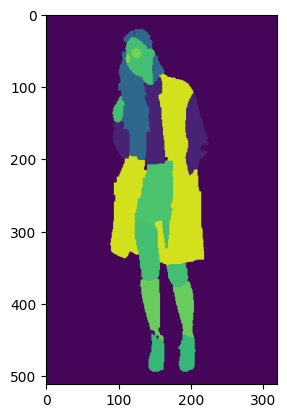

In [10]:
import numpy as np
import matplotlib.pyplot as plt

onehot_to_array = {v.tobytes(): k for k, v in array_to_onehot.items()}
def decode_image(image):
    return np.apply_along_axis(lambda pixel: np.frombuffer(onehot_to_array[pixel.tobytes()], dtype=np.uint8), 0, np.array(image, np.uint8)).transpose(1,2,0)
    


label = CustomClothingDataset(root_dir=DATASET_DIR).__getitem__(0)[1]
plt.imshow(decode_image(label))

In [11]:

image = Image.open(r"C:\Users\Usuario\PycharmProjects\aaiv\ClothingProject\data\labels\pixel_level_labels_colored\0001.png")


label = np.asarray(image, dtype=np.uint8)
codified = np.apply_along_axis(lambda pixel: array_to_onehot[pixel.tobytes()], 2, label)
label_ = torch.tensor(codified, dtype=torch.uint8)


In [12]:
label_.permute(2,0,1).shape

torch.Size([59, 832, 550])

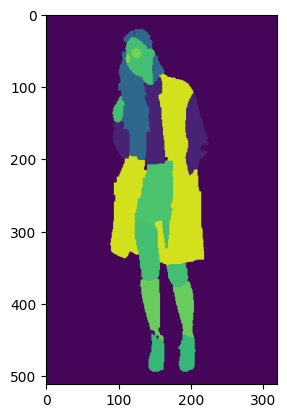

In [13]:
ca = label_.permute(2, 0, 1)
ca = CustomClothingDataset(root_dir=DATASET_DIR).__getitem__(0)[1]
plt.imshow(decode_image(ca))

Cantidad de imágenes:  1004


C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([59, 512, 320])


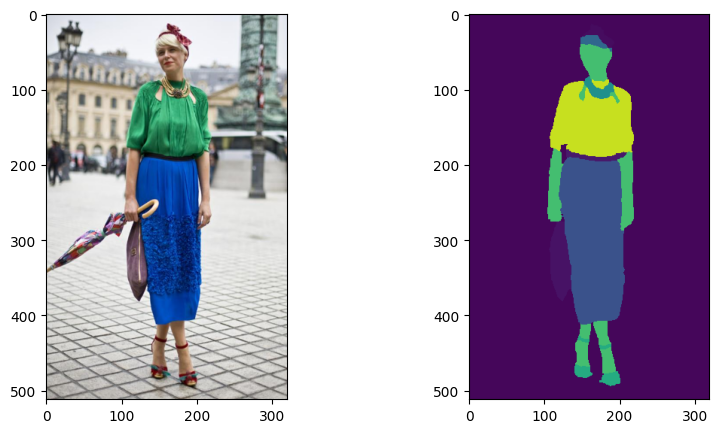

In [14]:
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

dataset = CustomClothingDataset(root_dir=DATASET_DIR,
                                transform_input=transforms.Compose([
                     transforms.Resize((512, 320)), #size mayor de las imagenes, para todas iguales sin perder información
                 ]),
                                transform_labels=transforms.Compose([transforms.Resize((512, 320), interpolation=InterpolationMode.NEAREST_EXACT)                                                                  
    ])
                                )
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Cantidad de imágenes: ", len(data_loader.dataset))

for image, label in data_loader:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(image[0].int(), (1, 2, 0)))
    plt.subplot(1, 2, 2)
    print(label[0].shape)
    plt.imshow(decode_image(label[0]))
    plt.show()
    break

## Implementación 1
### Modelo U-NET

Creación del modelo:

Hay que coger imagenes con el mismo grosor y altura para meterlos como input en la u-net, no vale `877x550` sino al mejor `560x560` para evitar coger el mayor porque puede generar ruido en la imagen, y tambien porque ese valor es divisible por 2 para pooling y unpooling, se prefiere compactarlo que generar ruido.

In [15]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 70)
        self.e2 = encoder_block(70, 140)
        self.e3 = encoder_block(140, 280)
        self.e4 = encoder_block(280, 560)

        """ Bottleneck """
        self.b = conv_block(560, 1120)

        """ Decoder """
        self.d1 = decoder_block(1120, 560)
        self.d2 = decoder_block(560, 280)
        self.d3 = decoder_block(280, 140)
        self.d4 = decoder_block(140, 70)

        """ Classifier """
        self.outputs = nn.Conv2d(70, 59, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs


#inputs = torch.randn((2, 3, 560, 560)).to(device)
inputs = torch.randn((4, 3, 512, 320))#.to(device)
model = build_unet()#.to(device)
y = model(inputs)
print(y.shape)

torch.Size([4, 59, 512, 320])


In [19]:
from torch.utils.data import random_split

BATCH_SIZE = 8
EPOCHS = 10
dataset = CustomClothingDataset(root_dir=DATASET_DIR) 
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
full_dataset = CustomClothingDataset(root_dir=DATASET_DIR)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss()


### Implementación U-NET

Epoch: 1, Train acc: 74.59661152288108, loss: 1.2369482774626126 //// Val acc: 49.8551025390625 loss: 1.810657080851103
Epoch: 2, Train acc: 78.92905819450004, loss: 0.8509967415170236 //// Val acc: 77.94234619140624 loss: 0.9030576348304749
Epoch: 3, Train acc: 79.69058305789261, loss: 0.788286033001813 //// Val acc: 78.14286702473959 loss: 0.8305938839912415
Epoch: 4, Train acc: 80.63173125612089, loss: 0.7368652312593027 //// Val acc: 79.24498697916665 loss: 0.792828525367536
Epoch: 5, Train acc: 81.20904906183229, loss: 0.7045372108166869 //// Val acc: 80.92175699869789 loss: 0.7377414922965201
Epoch: 6, Train acc: 81.80145785339876, loss: 0.6849920790303837 //// Val acc: 80.06229248046876 loss: 0.770685707267962
Epoch: 7, Train acc: 81.87941765853145, loss: 0.6658255647529255 //// Val acc: 79.18582763671876 loss: 0.9217094057484677
Epoch: 8, Train acc: 82.35448505803726, loss: 0.6419096426530317 //// Val acc: 82.93373616536458 loss: 0.6244409303916129
Epoch: 9, Train acc: 82.80156

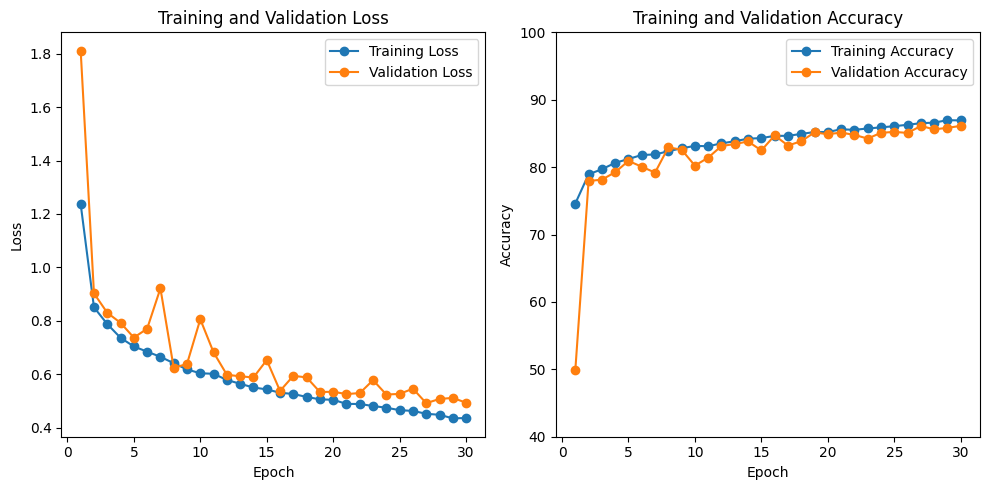

Test Accuracy: 122.7%, Avg loss: 0.498580 


In [17]:
from classes import ModelTrainer, EarlyStopper
device = "cuda"
model = build_unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
TrainNNObject = ModelTrainer(model, optimizer, loss_fn, 40, EarlyStopper(), device)
TrainNNObject.train_and_val(train_loader, val_loader)
TrainNNObject.draw_results()
TrainNNObject.test(test_loader)

In [22]:
#torch.save(model, "u-net.pth")

## Otras implementaciones

Para más implementaciones, se consideran dos modelos que son distintos uno al otro, dado que uno es considerado un modelo grande y otro, pequeño.
Ambos utilizan la versión de **DeepLabV3**, preentrenado en ImageNet como _"espinazo"_ (backbone), esto significa que ha aprendido representaciones útiles de una amplia variedad de imágenes. 
- La **ResNet50** es conocida por su profundidad y capacidad para capturar características complejas. Al tener 50 capas, puede aprender representaciones jerárquicas profundas que podrían ser beneficiosas para tareas de segmentación más complejas. Ayuda a mitigar el problema de desvanecimiento del gradiente, lo que facilita el entrenamiento de modelos más profundos.
- La **MobileNetV3**, es conocida por su eficiencia computacional y su capacidad para ejecutarse en dispositivos con recursos limitados. En este caso ya que tenemos a nuestra disposición una GPU y poseemos los recursos, se usa la versión _large_. Aunque, tiene menos parámetros en comparación con modelos más grandes (ResNet50), lo que puede ser beneficioso para tareas donde el conjunto de datos no es extremadamente grande.

#### Consideraciones Adicionales
Ambos modelos se benefician de la transferencia de aprendizaje al ser preentrenados en conjuntos de datos grandes como ImageNet. Esto puede ser beneficioso cuando se tiene un conjunto de datos más pequeño, ya que el modelo ya ha aprendido características útiles.

In [20]:
from models_segmentation import ResNet50Segmentation, MobileNetV3Segmentation

#### ResNet50

In [21]:
resnet50_model = ResNet50Segmentation(num_classes=59) #incluyendo el NONE
resnet50_model = resnet50_model.to("cuda")

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
import pandas as pd
import torch
from matplotlib import pyplot as plt


class EarlyStopper:
    def __init__(self, patience=2, min_delta=0.1):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


class Resnet18Trainer:

    def __init__(self, model, optimizer, loss_fn, epochs, early_stopper, device):
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.result = pd.DataFrame(columns=["Epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
        self.early_stopper = early_stopper

    def train_and_val(self, training_loader, val_loader, silent=False):
        for i in range(1, self.epochs + 1):
            train_loss, train_acc = self.train(training_loader)
            val_loss, val_acc = self.validate(val_loader)
            self.result.loc[len(self.result)] = (i,) + (train_loss, train_acc) + (val_loss, val_acc)
            if not silent:
                print("Epoch: " + str(i) + ", Train acc: " + str(train_acc) + ", loss: " + str(
                    train_loss) + " //// Val acc: " + str(val_acc) + " loss: " + str(val_loss))
            if self.early_stopper.early_stop(val_loss):
                self.epochs = i + 1
                break

    def train(self, training_loader):
        running_loss = 0.
        acc_sum = 0
        self.model.train()
        for i, data in enumerate(training_loader):
            # Every data instance is an input + label pair
            inputs, labels = data[0].to(self.device), data[1].to(self.device)
            # Make predictions for this batch
            outputs = self.model(inputs)['out'].to(self.device)
            # Compute the loss and its gradients
            loss = self.loss_fn(outputs, torch.argmax(labels, dim=1))
            loss.backward()
            # Adjust learning weights
            self.optimizer.step()
            # Zero your gradients for every batch!
            self.optimizer.zero_grad()
            # Gather data and report
            running_loss += loss.item()
            acc_sum += (outputs.argmax(1) == torch.argmax(labels, dim=1)).type(torch.float).sum().item() / (512 * 320)

        train_loss = running_loss / len(training_loader)  # perdida media de la época por batch
        acc = 100 * (acc_sum / len(training_loader.dataset))  # acc media de la época
        return train_loss, acc

    def validate(self, val_loader):
        self.model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)['out']
                val_loss += self.loss_fn(outputs, torch.argmax(labels, dim=1)).item()
                correct += (outputs.argmax(1) == torch.argmax(labels, dim=1)).type(torch.float).sum().item() / (
                            512 * 320)
        val_loss /= len(val_loader)
        val_acc = 100 * correct / len(val_loader.dataset)
        return val_loss, val_acc

    def draw_results(self):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.result["Epoch"], self.result["train_loss"], label='Training Loss', marker='o')
        plt.plot(self.result["Epoch"], self.result["val_loss"], label='Validation Loss', marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        # Plotting Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.result["Epoch"], self.result["train_acc"], label='Training Accuracy', marker='o')
        plt.plot(self.result["Epoch"], self.result["val_acc"], label='Validation Accuracy', marker='o')
        plt.xlabel('Epoch')
        plt.ylim(40, 100)
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')
        # Adjust layout to prevent overlap
        plt.tight_layout()
        # Show the plot
        plt.show()

    def test(self, test_loader):
        self.model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)['out']
                test_loss += self.loss_fn(outputs, torch.argmax(labels, dim=1)).item()
                correct += (outputs.argmax(1) == torch.argmax(labels, dim=1)).type(torch.float).sum().item() / (
                            512 * 224)
        test_loss /= len(test_loader)
        test_acc = 100 * correct / len(test_loader.dataset)
        print(f"Test Accuracy: {test_acc:>0.1f}%, Avg loss: {test_loss:>8f} \n")


optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.005)
resnet50_trainer = Resnet18Trainer(resnet50_model, optimizer, loss_fn, 10, EarlyStopper(), device)
resnet50_trainer.train_and_val(train_loader, val_loader)

Epoch: 1, Train acc: 76.31854717548077, loss: 0.9593519134954973 //// Val acc: 76.39337158203128 loss: 0.8938526699417516
Epoch: 2, Train acc: 80.64996181390224, loss: 0.6908568570559676 //// Val acc: 81.60460205078125 loss: 0.6441472925637898
Epoch: 3, Train acc: 82.00648728938525, loss: 0.6332109062509104 //// Val acc: 81.99615478515625 loss: 0.634633028193524
Epoch: 4, Train acc: 82.70423476172985, loss: 0.6045359413732182 //// Val acc: 81.3646240234375 loss: 0.6577620506286621
Epoch: 5, Train acc: 83.58123779296879, loss: 0.5752760188823397 //// Val acc: 80.46429850260417 loss: 0.6759162074641177
Epoch: 6, Train acc: 83.80264325698896, loss: 0.5573849549347704 //// Val acc: 83.73450520833332 loss: 0.571529496657221
Epoch: 7, Train acc: 84.47607665320065, loss: 0.5356220203367147 //// Val acc: 84.59897867838542 loss: 0.5309215046857533
Epoch: 8, Train acc: 84.80278602013217, loss: 0.5197219902818854 //// Val acc: 83.95098470052083 loss: 0.5355414058032789
Epoch: 9, Train acc: 85.257

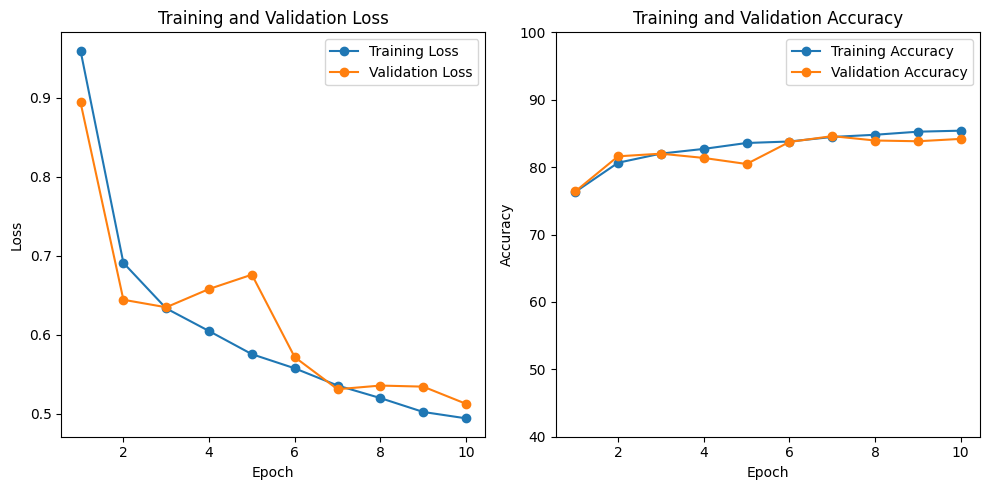

In [23]:
resnet50_trainer.draw_results()

In [24]:
resnet50_trainer.test(test_loader)

Test Accuracy: 120.4%, Avg loss: 0.527193 


In [ ]:
resnet50_output = resnet50_model(item.unsqueeze(0)).to("cpu")
resnet50_prediction = torch.argmax(resnet50_output, 1)
resnet50_mask = torch.zeros(resnet50_output.shape, dtype=torch.uint8).scatter(1, resnet50_prediction.unsqueeze(1), 1.0)
plt.imshow(decode_image(resnet50_mask[0]))

#### MobileNetV3

In [25]:
import torchvision.models.segmentation as segmentation
import torch.nn as nn

class MobileNetV3Segmentation(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV3Segmentation, self).__init__()
        # Large en el sentido de complejidad computacional
        self.model = segmentation.deeplabv3_mobilenet_v3_large(pretrained=True, progress=True)
        # Ajustar la penúltima capa si se quisiera tambien
        # in_features = self.model.classifier[-2].in_channels
        # self.model.classifier[-2] = nn.Conv2d(in_features, num_classes, kernel_size=1)

        # 1280 canales entrada predefinidos en la última capa, canales especificadas por clases como salida

        self.model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        return self.model(x)


mobilenetv3_model = MobileNetV3Segmentation(num_classes=59)
mobilenetv3_model = mobilenetv3_model.to("cuda")

C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\interpreters\python\aaiv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
from torch.utils.data import random_split

BATCH_SIZE = 4
EPOCHS = 10
dataset = CustomClothingDataset(root_dir=DATASET_DIR, transform_input=transforms.Compose([
                     transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST), #size mayor de las imagenes, para todas iguales sin perder información, esta ligeramente reducido para ser divisible por 16 (necesario para U-net
                     transforms.Lambda(lambda x: x / 255), # reescalo de 0 a 1
                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# normalizo
                 ]),
                 transform_labels=transforms.Compose([
                    transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
                 ])) 
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
full_dataset = CustomClothingDataset(root_dir=DATASET_DIR)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenetv3_model.parameters(), lr=0.005)
mobilenetv3_trainer = Resnet18Trainer(mobilenetv3_model, optimizer, loss_fn, 10, EarlyStopper(), device)
mobilenetv3_trainer.train_and_val(train_loader, val_loader)

Epoch: 1, Train acc: 80.61428146144944, loss: 0.7343450186943467 //// Val acc: 78.95891520182292 loss: 0.8339065156484905
Epoch: 2, Train acc: 83.85374150724493, loss: 0.5669614625248042 //// Val acc: 81.51480305989583 loss: 0.7696068365322916
Epoch: 3, Train acc: 84.68356749271055, loss: 0.5304313176734881 //// Val acc: 81.20155029296873 loss: 0.7430763134830877
Epoch: 4, Train acc: 85.18113008591526, loss: 0.5047479078850963 //// Val acc: 82.71365966796876 loss: 0.6286442695479644
Epoch: 5, Train acc: 85.6825999724559, loss: 0.4841710862449624 //// Val acc: 85.609619140625 loss: 0.5093624732996288
Epoch: 6, Train acc: 85.53826226128476, loss: 0.49041743525727227 //// Val acc: 85.1523193359375 loss: 0.5354136903035013
Epoch: 7, Train acc: 86.19306515424682, loss: 0.46341248364611104 //// Val acc: 85.71179199218747 loss: 0.5001335159728402
Epoch: 8, Train acc: 86.54167153556804, loss: 0.4474301754750989 //// Val acc: 84.97306722005207 loss: 0.5134378663803402
Epoch: 9, Train acc: 86.81

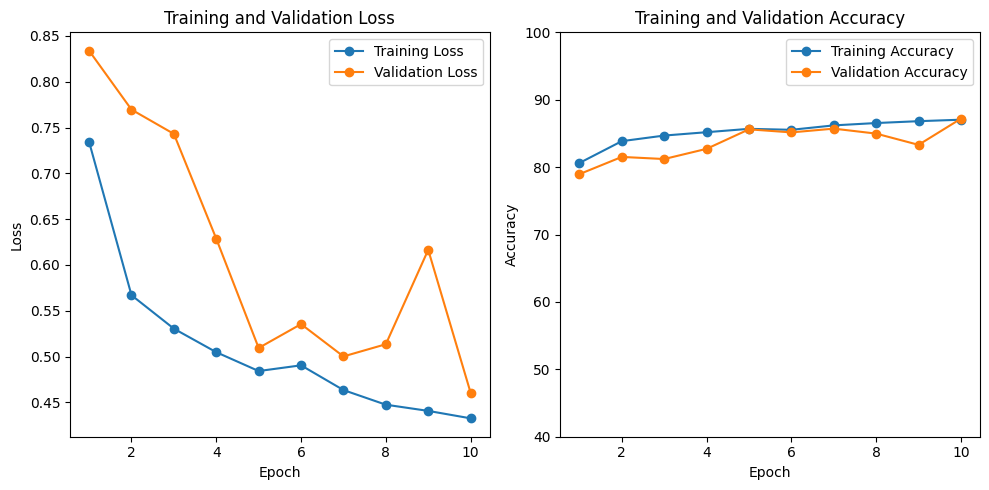

In [27]:
mobilenetv3_trainer.draw_results()

In [28]:
mobilenetv3_trainer.test(test_loader)

Test Accuracy: 122.8%, Avg loss: 0.492481 


In [29]:
mobilenetv3_output = mobilenetv3_model(item_test.unsqueeze(0)).to("cpu")
mobilenetv3_prediction = torch.argmax(mobilenetv3_output, 1)
mobilenetv3_mask = torch.zeros(mobilenetv3_output.shape, dtype=torch.uint8).scatter(1, mobilenetv3_prediction.unsqueeze(1), 1.0)
plt.imshow(decode_image(mobilenetv3_mask[0]))

NameError: name 'item_test' is not defined